# Get the Data

In [1]:
import os

DATASETS_DIR = 'datasets'
MODELS_DIR = 'models'
TAR_DIR = os.path.join(DATASETS_DIR, 'tar')

SPAM_URL = 'https://spamassassin.apache.org/old/publiccorpus/20050311_spam_2.tar.bz2'
EASY_HAM_URL = 'https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham_2.tar.bz2'
HARD_HAM_URL = 'https://spamassassin.apache.org/old/publiccorpus/20030228_hard_ham.tar.bz2'

In [2]:
from urllib.request import urlretrieve
import tarfile
import shutil

def download_dataset(url):
    """download and unzip data from a url into the specified path"""
    
    # create directory if it doesn't exist
    if not os.path.isdir(TAR_DIR):
        os.makedirs(TAR_DIR)
    
    filename = url.rsplit('/', 1)[-1]
    tarpath = os.path.join(TAR_DIR, filename)
    
    # download the tar file if it doesn't exist
    try:
        tarfile.open(tarpath)
    except:
        urlretrieve(url, tarpath)
    
    with tarfile.open(tarpath) as tar:
        dirname = os.path.join(DATASETS_DIR, tar.getnames()[0])
        if os.path.isdir(dirname):
            shutil.rmtree(dirname)
        tar.extractall(path=DATASETS_DIR)
        
        cmds_path = os.path.join(dirname, 'cmds')
        if os.path.isfile(cmds_path):
            os.remove(cmds_path)
    
    return dirname

In [3]:
# download the data
spam_dir = download_dataset(SPAM_URL)

In [4]:
easy_ham_dir = download_dataset(EASY_HAM_URL)

In [5]:
hard_ham_dir = download_dataset(HARD_HAM_URL)

In [6]:
import numpy as np
import glob

def load_dataset(dirpath):
    """load emails from the specified directory"""
    
    files = []
    filepaths = glob.glob(dirpath + '/*')
    for path in filepaths:
        with open(path, 'rb') as f:
            byte_content = f.read()
            str_content = byte_content.decode('utf-8', errors='ignore')
            files.append(str_content)
    return files
    

In [7]:
# load the datasets
spam = load_dataset(spam_dir)
easy_ham = load_dataset(easy_ham_dir)
hard_ham = load_dataset(hard_ham_dir)

In [8]:
import sklearn.utils

# create the full dataset
X = spam + easy_ham + hard_ham
y = np.concatenate((np.ones(len(spam)), np.zeros(len(easy_ham) + len(hard_ham))))

# shuffle the dataset
X, y = sklearn.utils.shuffle(X, y, random_state=42)

In [9]:
from sklearn.model_selection import train_test_split

# split the data into stratified training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=42)

In [10]:
# check dataset shapes
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

2436 2436
610 610


# Data Preparation Pipeline

In [11]:
def remove_header(email):
    """remove the header from an email"""
    return email[email.index('\n\n'):]

In [12]:
import re 

def is_url(s):
    url = re.match("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|"
                     "[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", s)
    return url is not None

def convert_url_to_word(words):
    """convert all urls in the list to the word 'URL'"""
    for i, word in enumerate(words):
        if is_url(word):
            words[i] = 'URL'
    return words

In [13]:
def convert_num_to_word(words):
    """convert all numbers in the list to the word 'NUM'"""
    for i, word in enumerate(words):
        if word.isdigit():
            words[i] = 'NUM'
    return words

In [14]:
def remove_punctuation(email):
    new_email = ""
    for c in email:
        if c.isalnum() or c.isspace():
            new_email += c
    return new_email

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class CleanEmails(BaseEstimator, TransformerMixin):
    def __init__(self, no_header=True, to_lowercase=True, url_to_word=True, num_to_word=True,
                 remove_punc=True):
        self.no_header = no_header
        self.to_lowercase = to_lowercase
        self.url_to_word = url_to_word
        self.num_to_word = num_to_word
        self.remove_punc = remove_punc
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_cleaned = []
        for email in X:
            if self.no_header:
                email = remove_header(email)
            if self.to_lowercase:
                email = email.lower()
            
            email_words = email.split()
            if self.url_to_word:
                email_words = convert_url_to_word(email_words)
            if self.num_to_word:
                email_words = convert_num_to_word(email_words)
            email = ' '.join(email_words)
            if self.remove_punc:
                email = remove_punctuation(email)
            X_cleaned.append(email)
        return X_cleaned
        

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

# full preparation pipeline
prepare_pipeline = Pipeline([
    ('clean_email', CleanEmails()),
    ('bag_of_words', CountVectorizer())
])

In [17]:
# prepare the training data
X_train_prepared = prepare_pipeline.fit_transform(X_train)

In [18]:
print(X_train_prepared.shape)

(2436, 94842)


# Train and Evaluate some Classifiers

## Classifiers to try
- SGDClassifier
- MLPClassifier
- DecisionTreeClassifier
- RandomForestClassifier
- AdaBoostClassifier
- KNNClassifier
- SVC

## How to evaluate each classifier
- Using 3-fold cross validation:
 - Evaluate accuracy
 - Calculate the confusion matrix, precision, recall and f1-score
- Select some promising models
 - For models that implement decision_function() or predict_probas(),
  - Plot the precision vs recall curve
  - Plot ROC curve and calculate the ROC AUC
- Pick the classifier with best precision and recall

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

def eval_confusion(y_pred, y_true=y_train):
    conf_matrix = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return {'matrix': conf_matrix, 'precision': precision, 'recall': recall, 'f1': f1}

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [21]:
import warnings

# stop scikit-learn's deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [22]:
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# classification models
sgd_clf = SGDClassifier(random_state=42, max_iter=100)
mlp_clf = MLPClassifier(hidden_layer_sizes=(16,))
tree_clf = DecisionTreeClassifier()
forest_clf = RandomForestClassifier()
adaboost_clf = AdaBoostClassifier()
knn_clf = KNeighborsClassifier()
svm_clf = SVC()

classifiers = {
    'SGD': sgd_clf,
    'Decision Tree': tree_clf,
    'Random Forest': forest_clf,
    'AdaBoost': adaboost_clf,
    'KNN': knn_clf,
    'SVM': svm_clf,
    'MLP': mlp_clf
}

In [23]:
from sklearn.model_selection import cross_val_predict

# make predictions using each model
y_preds = {}
for clf_name, clf in classifiers.items():
    y_preds[clf_name] = cross_val_predict(clf, X_train_prepared, y_train, cv=3)

In [24]:
from sklearn.metrics import accuracy_score

# evaluate each classifier's accuracy
for clf_name, y_pred in y_preds.items():
    print("{}:".format(clf_name))
    print(accuracy_score(y_train, y_pred))
    print()

SGD:
0.9527914614121511

Decision Tree:
0.9137931034482759

Random Forest:
0.9339080459770115

AdaBoost:
0.9466338259441708

KNN:
0.9055829228243021

SVM:
0.6711822660098522

MLP:
0.9753694581280788



In [25]:
# evaluate the confusion matrix, precision, recall and f1 score for each classifier
for clf_name, y_pred in y_preds.items():
    conf = eval_confusion(y_pred)
    print("{}:".format(clf_name))
    print(conf['matrix'])
    print("precision: {}".format(conf['precision']))
    print("recall: {}".format(conf['recall']))
    print("f1-score: {}".format(conf['f1']))
    print()

SGD:
[[1262   58]
 [  57 1059]]
precision: 0.9480752014324082
recall: 0.9489247311827957
f1-score: 0.948499776085983

Decision Tree:
[[1215  105]
 [ 105 1011]]
precision: 0.9059139784946236
recall: 0.9059139784946236
f1-score: 0.9059139784946236

Random Forest:
[[1281   39]
 [ 122  994]]
precision: 0.9622458857696031
recall: 0.8906810035842294
f1-score: 0.9250814332247558

AdaBoost:
[[1252   68]
 [  62 1054]]
precision: 0.9393939393939394
recall: 0.9444444444444444
f1-score: 0.9419124218051832

KNN:
[[1217  103]
 [ 127  989]]
precision: 0.9056776556776557
recall: 0.8862007168458781
f1-score: 0.8958333333333333

SVM:
[[1288   32]
 [ 769  347]]
precision: 0.9155672823218998
recall: 0.3109318996415771
f1-score: 0.46421404682274253

MLP:
[[1289   31]
 [  29 1087]]
precision: 0.9722719141323792
recall: 0.9740143369175627
f1-score: 0.973142345568487



- SVM doesn't seem to be promising
- Best model so far is the MLP classifier
- Second best model is the SGD classifier

In [26]:
from sklearn.model_selection import cross_val_predict

# calculate scores for each model
y_scores = {}
clf_thresholds = {}

for clf_name, clf in classifiers.items():
    method = 'predict_proba'
    if not hasattr(clf, 'predict_proba') and hasattr(clf, 'decision_function'):
        method = 'decision_function'
    y_scores[clf_name] = cross_val_predict(clf, X_train_prepared, y_train, cv=3,
                                           method=method)
    if method == 'predict_proba':
        y_scores[clf_name] = y_scores[clf_name][:,1]
        clf_thresholds[clf_name] = 0.5
    else:
        clf_thresholds[clf_name] = 0

In [30]:
from sklearn.metrics import precision_recall_curve

def plot_precision_vs_recall(y_scores, threshold=0, label=None, style='b-'):
    """plot precision vs recall for different thresholds, highlight the specified threshold"""
    
    # calculate scores and precisions and recalls at different thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
    
    # plot the precision and recall curves
    plt.plot(recalls, precisions, style, label=label)
    
    # highlight the threshold
    y_pred = y_scores >= threshold
    hl_precision = precision_score(y_train, y_pred)
    hl_recall = recall_score(y_train, y_pred)
    
    plt.plot([0, hl_recall], [hl_precision, hl_precision], 'r:')
    plt.plot([hl_recall, hl_recall], [0, hl_precision], 'r:')
    plt.plot([hl_recall], [hl_precision], 'ro')

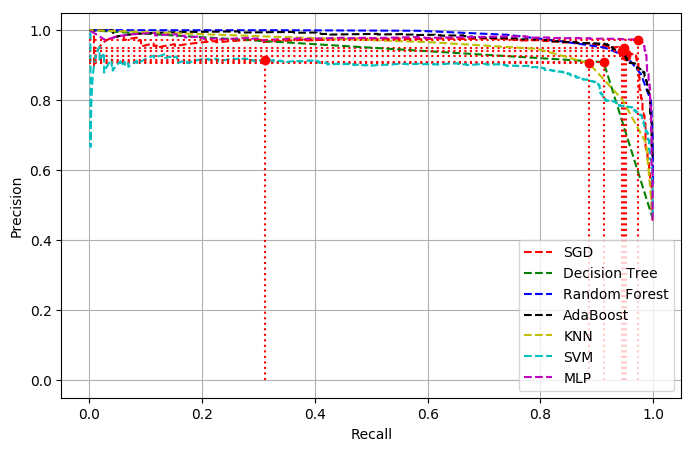

In [31]:
# plot recall vs precision for each model
mpl.style.use('default')
plt.figure(figsize=(8, 5))

styles = {
    'SGD': 'r--',
    'Decision Tree': 'g--',
    'Random Forest': 'b--',
    'AdaBoost': 'k--',
    'KNN': 'y--',
    'SVM': 'c--',
    'MLP': 'm--'
}

for clf_name, y_score in y_scores.items():
    plot_precision_vs_recall(y_score, threshold=clf_thresholds[clf_name], label=clf_name,
                             style=styles[clf_name])
    
plt.grid(True)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()

- SVM seems to have a good enough precision and about 0.9 recall
- The other classifiers have the best recall/precision tradeoffs at the default thresholds

In [34]:
# SVM at about 0.9 recall
svm_precisions, svm_recalls, svm_thresholds = precision_recall_curve(y_train, y_scores['SVM'])
svm_good_threshold = svm_thresholds[np.argmax((svm_recalls <= 0.9))]
svm_y_pred_good_th = y_scores['SVM'] >= svm_good_threshold
clf_thresholds['SVM'] = svm_good_threshold

print()
print("precision: {}".format(precision_score(y_train, svm_y_pred_good_th)))
print("recall: {}".format(recall_score(y_train, svm_y_pred_good_th)))


precision: 0.8494077834179357
recall: 0.899641577060932


In [35]:
from sklearn.metrics import roc_curve

def plot_roc(y_scores, threshold=0, label=None, style='b-'):
    """plot the ROC curve"""
    
    fpr, tpr, thresholds = roc_curve(y_train, y_scores)
    
    # plot the ROC curve
    plt.plot(fpr, tpr, style, label=label)
    
    # false positive rate: false positives / true negatives + false positives
    # true positive rate (recall): true positives / (true positives + false negatives)
    # highlight the threshold
    y_pred = y_scores > threshold
    hl_fp = np.sum(np.logical_and(y_pred == True, y_train == 0))
    hl_tp = np.sum(np.logical_and(y_pred == True, y_train == 1))
    hl_fpr = hl_fp / np.sum(y_train == 0)
    hl_tpr = hl_tp / np.sum(y_train == 1)
    
    plt.plot([0, hl_fpr], [hl_tpr, hl_tpr], 'r:')
    plt.plot([hl_fpr, hl_fpr], [0, hl_tpr], 'r:')
    plt.plot([hl_fpr], [hl_tpr], 'ro')

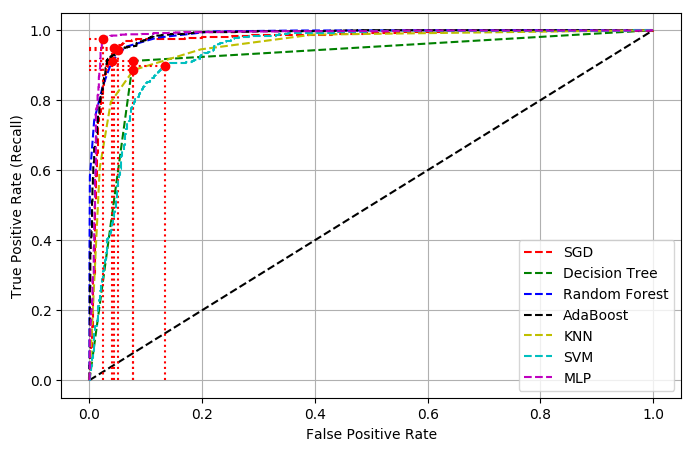

In [36]:
# plot ROC curve for each model
mpl.style.use('default')
plt.figure(figsize=(8, 5))

# ROC for purely random classifier
plt.plot([0, 1], [0, 1], 'k--')

for clf_name, y_score in y_scores.items():
    plot_roc(y_score, threshold=clf_thresholds[clf_name], label=clf_name, style=styles[clf_name])
    
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(loc='lower right')
plt.show()

In [37]:
# calculate all ROC AUCs
from sklearn.metrics import roc_auc_score

print("ROC AUC scores:")
for clf_name, y_score in y_scores.items():
    roc_auc = roc_auc_score(y_train, y_score)
    print("- {}: {}".format(clf_name, roc_auc))

ROC AUC scores:
- SGD: 0.9755885467579017
- Decision Tree: 0.917456826327794
- Random Forest: 0.9866093733029218
- AdaBoost: 0.9848912512218964
- KNN: 0.9544782502443794
- SVM: 0.9358735201477136
- MLP: 0.9871548142717498


## Best classifiers to fine-tune:
- MLP
- AdaBoost
- SVM

# Fine-tune the Best Classifiers

## To fine-tune each model:
- Use Grid Search or Random Search depending on the model type and use 5-fold CV
- Save each model to a file
- Evaluate the model on the test set

In [38]:
from sklearn.model_selection import GridSearchCV

# fine-tune MLP classifier
mlp_best = MLPClassifier()
mlp_param_grid = {
    'hidden_layer_sizes': [(16,), (16, 16), (32,)],
    'activation': ['relu', 'tanh', 'logistic']
}

mlp_grid_search = GridSearchCV(mlp_best, mlp_param_grid, 'f1', cv=5, verbose=2)
mlp_grid_search.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] activation=relu, hidden_layer_sizes=(16,) .......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ activation=relu, hidden_layer_sizes=(16,), total=  27.3s
[CV] activation=relu, hidden_layer_sizes=(16,) .......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.3s remaining:    0.0s


[CV] ........ activation=relu, hidden_layer_sizes=(16,), total=  28.2s
[CV] activation=relu, hidden_layer_sizes=(16,) .......................
[CV] ........ activation=relu, hidden_layer_sizes=(16,), total=  27.8s
[CV] activation=relu, hidden_layer_sizes=(16,) .......................
[CV] ........ activation=relu, hidden_layer_sizes=(16,), total=  27.2s
[CV] activation=relu, hidden_layer_sizes=(16,) .......................
[CV] ........ activation=relu, hidden_layer_sizes=(16,), total=  27.9s
[CV] activation=relu, hidden_layer_sizes=(16, 16) ....................
[CV] ..... activation=relu, hidden_layer_sizes=(16, 16), total=  23.7s
[CV] activation=relu, hidden_layer_sizes=(16, 16) ....................
[CV] ..... activation=relu, hidden_layer_sizes=(16, 16), total=  24.9s
[CV] activation=relu, hidden_layer_sizes=(16, 16) ....................
[CV] ..... activation=relu, hidden_layer_sizes=(16, 16), total=  22.4s
[CV] activation=relu, hidden_layer_sizes=(16, 16) ....................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 30.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'hidden_layer_sizes': [(16,), (16, 16), (32,)], 'activation': ['relu', 'tanh', 'logistic']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=2)

In [39]:
# fine-tune AdaBoost classifier
adaboost_best = AdaBoostClassifier()
adaboost_param_grid = {
    'n_estimators': [10, 30, 50, 100]
}

adaboost_grid_search = GridSearchCV(adaboost_best, adaboost_param_grid, 'f1', cv=5, verbose=2)
adaboost_grid_search.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. n_estimators=10, total=   1.4s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] .................................. n_estimators=10, total=   1.4s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   1.4s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   1.4s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   1.4s
[CV] n_estimators=30 .................................................
[CV] .................................. n_estimators=30, total=   4.0s
[CV] n_estimators=30 .................................................
[CV] .................................. n_estimators=30, total=   4.2s
[CV] n_estimators=30 .................................................
[CV] .................................. n_estimators=30, total=   3.9s
[CV] n_estimators=30 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 30, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=2)

In [40]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats

# fine-tune SVM classifier
svm_best = SVC()
svm_param_dist = {
    'kernel': ['linear', 'rbf'],
    'C': scipy.stats.reciprocal(20, 200000),
    'gamma': scipy.stats.expon(scale=1.0)
}

svm_randomized_search = RandomizedSearchCV(svm_best, svm_param_dist, n_iter=5, scoring='f1',
                                           cv=5, verbose=2, random_state=42)
svm_randomized_search.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   1.2s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   1.1s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   1.2s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   1.2s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   1.1s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=   6.2s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=   6.1s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=   6.4s
[CV] C=26290.2

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=5, n_jobs=None,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f52e8265c18>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f52e8265400>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='f1', verbose=2)

In [41]:
import joblib

def save_model(model, filename):
    # create directory if it doesn't exist
    if not os.path.isdir(MODELS_DIR):
        os.makedirs(MODELS_DIR)
        
    path = os.path.join(MODELS_DIR, filename)
    joblib.dump(model, path)

In [42]:
# get the best estimators
mlp_best = mlp_grid_search.best_estimator_
adaboost_best = adaboost_grid_search.best_estimator_
svm_best = svm_randomized_search.best_estimator_

# save each model
save_model(mlp_best, 'mlp_best.pkl')
save_model(adaboost_best, 'adaboost_best.pkl')
save_model(svm_best, 'svm_best.pkl')

In [43]:
# evaluate each model on the training set
best_clf = {
    'MLP': mlp_best,
    'AdaBoost': adaboost_best,
    'SVM': svm_best
}

for clf_name, clf in best_clf.items():
    y_pred = clf.predict(X_train_prepared)
    conf = eval_confusion(y_pred, y_train)
    print("{}:".format(clf_name))
    print(conf['matrix'])
    print("precision: {}".format(conf['precision']))
    print("recall: {}".format(conf['recall']))
    print("f1-score: {}".format(conf['f1']))
    print("accuracy: {}".format(accuracy_score(y_pred, y_train)))
    print()

MLP:
[[1320    0]
 [   1 1115]]
precision: 1.0
recall: 0.9991039426523297
f1-score: 0.9995517705064992
accuracy: 0.9995894909688013

AdaBoost:
[[1315    5]
 [  10 1106]]
precision: 0.9954995499549955
recall: 0.9910394265232975
f1-score: 0.9932644813650651
accuracy: 0.9938423645320197

SVM:
[[1320    0]
 [   0 1116]]
precision: 1.0
recall: 1.0
f1-score: 1.0
accuracy: 1.0



In [44]:
# prepare the test dataset
X_test_prepared = prepare_pipeline.transform(X_test)

# evaluate each model on the test set
for clf_name, clf in best_clf.items():
    y_pred = clf.predict(X_test_prepared)
    conf = eval_confusion(y_pred, y_test)
    print("{}:".format(clf_name))
    print(conf['matrix'])
    print("precision: {}".format(conf['precision']))
    print("recall: {}".format(conf['recall']))
    print("f1-score: {}".format(conf['f1']))
    print("accuracy: {}".format(accuracy_score(y_pred, y_test)))
    print()
    

MLP:
[[325   5]
 [  3 277]]
precision: 0.9822695035460993
recall: 0.9892857142857143
f1-score: 0.9857651245551601
accuracy: 0.9868852459016394

AdaBoost:
[[321   9]
 [  5 275]]
precision: 0.9683098591549296
recall: 0.9821428571428571
f1-score: 0.975177304964539
accuracy: 0.9770491803278688

SVM:
[[322   8]
 [  2 278]]
precision: 0.972027972027972
recall: 0.9928571428571429
f1-score: 0.9823321554770317
accuracy: 0.9836065573770492



The best classifier is the MLP classifier with about:
- 98.7% accuracy
- 98.2% precision
- 98.9% recall
- 98.6% f1-score